<a href="https://colab.research.google.com/github/Ahlawatash/Weather-Assignment/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [ ]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install requests
!pip install matplotlib
!pip install pyinputplus
!pip install pandas
!pip install hands-on-ai


In [ ]:
import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
os.environ['HANDS_ON_AI_API_KEY'] = '29e060f713934fef81330206ee7b9842.m8axTsN_eQbon2ajZvmLV42e'

## 📦 Setup and Configuration
Import required packages and setup environment.

In [ ]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
import pandas as pd
from datetime import datetime


# Add any other setup code here

## 🌤️ Weather Data Functions

In [26]:
# Define get_weather_data() function here
# 🌦️ Weather Data Functions + Interactive Menu

import requests
from datetime import datetime

WTTR_URL = "https://wttr.in/{loc}?format=j1"

def _safe_float(x, default=None):
    """Safely convert a value to float (or return None if missing)."""
    try:
        return float(x)
    except Exception:
        return default

def get_current_weather(location: str) -> dict:
    """
    Return current weather for a location using wttr.in (no API key).
    Keys returned: time, temperature_c, feels_like_c, weather_text, humidity_pct, precip_mm, wind_kmh
    """
    url = WTTR_URL.format(loc=location)
    r = requests.get(url, timeout=20)
    r.raise_for_status()
    data = r.json()

    cc = (data.get("current_condition") or [{}])[0]
    desc_list = cc.get("weatherDesc") or []
    weather_text = desc_list[0].get("value") if isinstance(desc_list, list) and desc_list else None

    return {
        "location": location,
        "time": cc.get("localObsDateTime") or cc.get("observation_time"),
        "temperature_c": _safe_float(cc.get("temp_C")),
        "feels_like_c": _safe_float(cc.get("FeelsLikeC")),
        "weather_text": weather_text,
        "humidity_pct": _safe_float(cc.get("humidity")),
        "precip_mm": _safe_float(cc.get("precipMM")),
        "wind_kmh": _safe_float(cc.get("windspeedKmph")),
    }

def get_weather_data(location, forecast_days=3):
    """
    Retrieve current + multi-day forecast for a specified location (1–5 days).
    Returns {"current": {...}, "forecast": [{date,min_temp,max_temp,avg_humidity,precip_mm}, ...]}
    """
    # Clamp days to 1..5 and to available days
    forecast_days = max(1, min(int(forecast_days), 5))

    url = WTTR_URL.format(loc=location)
    r = requests.get(url, timeout=20)
    r.raise_for_status()
    data = r.json()

    current = get_current_weather(location)
    days = data.get("weather") or []
    forecast = []
    for d in days[:forecast_days]:
        hourly = d.get("hourly") or []
        avg_hum = (sum(_safe_float(h.get("humidity"), 0.0) for h in hourly) / len(hourly)) if hourly else None
        precip = sum(_safe_float(h.get("precipMM"), 0.0) for h in hourly) if hourly else None

        forecast.append({
            "date": d.get("date"),
            "min_temp": _safe_float(d.get("mintempC")),
            "max_temp": _safe_float(d.get("maxtempC")),
            "avg_humidity": avg_hum,
            "precip_mm": precip,
        })

    return {"current": current, "forecast": forecast}

# ---------- Printing helpers ----------
def _print_card(now: dict):
    """Pretty print full weather card (current conditions)."""
    print(
        f"📍 {now['location']}\n"
        f"🕒 {now['time']}\n"
        f"🌡️ Temp: {now['temperature_c']} °C (feels {now['feels_like_c']} °C)\n"
        f"⛅ {now['weather_text']}\n"
        f"💧 Humidity: {now['humidity_pct']} %   🌧️ Precip: {now['precip_mm']} mm\n"
        f"🌬️ Wind: {now['wind_kmh']} km/h"
    )

def _print_attribute(now: dict, choice: str):
    """Print a single CURRENT attribute based on menu choice."""
    choice = choice.lower()
    if choice == "temperature":
        print(f"🌡️ Temperature: {now['temperature_c']} °C (feels {now['feels_like_c']} °C)")
    elif choice == "precipitation":
        print(f"🌧️ Precipitation: {now['precip_mm']} mm")
    elif choice == "weather":
        print(f"⛅ Weather: {now['weather_text']}")
    elif choice == "humidity":
        print(f"💧 Humidity: {now['humidity_pct']} %")
    elif choice == "all":
        _print_card(now)
    else:
        print("❓ Unknown choice")

def _print_forecast_table(forecast: list, city: str):
    """Neat textual table for multi-day forecast."""
    if not forecast:
        print("No forecast data available.")
        return
    print(f"\n📅 Forecast for {city}:")
    for d in forecast:
        try:
            label = datetime.strptime(d["date"], "%Y-%m-%d").strftime("%a %d %b")
        except Exception:
            label = d["date"]
        min_t = d.get("min_temp")
        max_t = d.get("max_temp")
        hum   = d.get("avg_humidity")
        pmm   = d.get("precip_mm")
        hum_s = f"{round(hum)}%" if hum is not None else "—"
        pmm_s = f"{round(pmm,1)} mm" if pmm is not None else "—"
        print(f"  {label}: {min_t}–{max_t}°C | 💧 {pmm_s} | 🌫️ Humidity ~{hum_s}")

# ---------- Interactive CLI (now includes Forecast option) ----------
def run_current_weather_cli(default_city: str = None):
    """
    Interactive program:
      - Ask user for a city
      - Menu:
          1 Temperature (current)
          2 Precipitation (current)
          3 Weather (current)
          4 Humidity (current)
          5 All (current card)
          6 Forecast (1–5 days)
          7 Change city
          8 Quit
    """
    city = default_city
    while True:
        if not city:
            city = input("\nEnter a city (e.g., Sydney, Delhi, New York): ").strip()
            if not city:
                print("Please enter a valid city name.")
                continue

        try:
            now = get_current_weather(city)
        except Exception as e:
            print(f"⚠️ Could not fetch data for '{city}'. Error: {e}")
            city = None
            continue

        print("\nChoose an option:")
        print(" 1) Temperature (current)\n 2) Precipitation (current)\n 3) Weather (current)\n 4) Humidity (current)"
              "\n 5) All (current card)\n 6) Forecast (1–5 days)\n 7) Change city\n 8) Quit")
        choice = input("\nEnter a number 1-8 and press Enter: ").strip()

        if choice == "1":
            _print_attribute(now, "temperature")
        elif choice == "2":
            _print_attribute(now, "precipitation")
        elif choice == "3":
            _print_attribute(now, "weather")
        elif choice == "4":
            _print_attribute(now, "humidity")
        elif choice == "5":
            _print_attribute(now, "all")
        elif choice == "6":
            try:
                days_str = input("How many days (1–5)? ").strip()
                days = int(days_str)
                wd = get_weather_data(city, forecast_days=days)
                _print_forecast_table(wd["forecast"], city)
            except Exception as e:
                print(f"⚠️ Couldn't show forecast: {e}")
        elif choice == "7":
            city = input("Enter a new city: ").strip()
        elif choice == "8":
            print("👋 Bye!")
            break
        else:
            print("❌ Invalid option, please try again.")

# Run the interactive program
run_current_weather_cli()




Enter a city (e.g., Sydney, Delhi, New York): delhi

Choose an option:
 1) Temperature (current)
 2) Precipitation (current)
 3) Weather (current)
 4) Humidity (current)
 5) All (current card)
 6) Forecast (1–5 days)
 7) Change city
 8) Quit

Enter a number 1-8 and press Enter: 6
How many days (1–5)? 4
⚠️ Couldn't show forecast: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

Choose an option:
 1) Temperature (current)
 2) Precipitation (current)
 3) Weather (current)
 4) Humidity (current)
 5) All (current card)
 6) Forecast (1–5 days)
 7) Change city
 8) Quit

Enter a number 1-8 and press Enter: 6
How many days (1–5)? 2

📅 Forecast for delhi:
  Fri 17 Oct: 25.0–33.0°C | 💧 0.0 mm | 🌫️ Humidity ~32%
  Sat 18 Oct: 25.0–33.0°C | 💧 0.0 mm | 🌫️ Humidity ~32%

Choose an option:
 1) Temperature (current)
 2) Precipitation (current)
 3) Weather (current)
 4) Humidity (current)
 5) All (current card)
 6) Forecast (1–5 days)
 7) Change city
 8) Quit

Enter a num

KeyboardInterrupt: Interrupted by user

## 📊 Visualisation Functions

In [32]:
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
# 🌤️ WeatherWise: Complete Current + Forecast + Visualisation Interactive Program

import requests
from datetime import datetime
import matplotlib.pyplot as plt

WTTR_URL = "https://wttr.in/{loc}?format=j1"

# ---------- Helper ----------
def _safe_float(x, default=None):
    """Safely convert a value to float (or return None if missing)."""
    try:
        return float(x)
    except Exception:
        return default

# ---------- Weather Data ----------
def get_current_weather(location: str) -> dict:
    """Return current weather for a location using wttr.in (no API key)."""
    url = WTTR_URL.format(loc=location)
    r = requests.get(url, timeout=20)
    r.raise_for_status()
    data = r.json()

    cc = (data.get("current_condition") or [{}])[0]
    desc_list = cc.get("weatherDesc") or []
    weather_text = desc_list[0].get("value") if isinstance(desc_list, list) and desc_list else None

    return {
        "location": location,
        "time": cc.get("localObsDateTime") or cc.get("observation_time"),
        "temperature_c": _safe_float(cc.get("temp_C")),
        "feels_like_c": _safe_float(cc.get("FeelsLikeC")),
        "weather_text": weather_text,
        "humidity_pct": _safe_float(cc.get("humidity")),
        "precip_mm": _safe_float(cc.get("precipMM")),
        "wind_kmh": _safe_float(cc.get("windspeedKmph")),
    }

def get_weather_data(location, forecast_days=3):
    """Retrieve current + multi-day forecast for a specified location (1–5 days)."""
    forecast_days = max(1, min(int(forecast_days), 5))
    url = WTTR_URL.format(loc=location)
    r = requests.get(url, timeout=20)
    r.raise_for_status()
    data = r.json()

    current = get_current_weather(location)
    days = data.get("weather") or []
    forecast = []
    for d in days[:forecast_days]:
        hourly = d.get("hourly") or []
        avg_hum = (sum(_safe_float(h.get("humidity"), 0.0) for h in hourly) / len(hourly)) if hourly else None
        precip = sum(_safe_float(h.get("precipMM"), 0.0) for h in hourly) if hourly else None
        forecast.append({
            "date": d.get("date"),
            "min_temp": _safe_float(d.get("mintempC")),
            "max_temp": _safe_float(d.get("maxtempC")),
            "avg_humidity": avg_hum,
            "precip_mm": precip,
        })

    return {"current": current, "forecast": forecast}

# ---------- Visualisations ----------
def create_temperature_visualisation(weather_data: dict, output_type: str = 'display'):
    """Plot daily min/max temperatures from weather_data['forecast']."""
    days = weather_data.get("forecast", [])
    if not days:
        raise ValueError("No forecast data found. Call get_weather_data(city, forecast_days>=1).")

    x_dates, y_min, y_max = [], [], []
    for d in days:
        ds = d.get("date")
        if not ds: continue
        try:
            dt = datetime.strptime(ds, "%Y-%m-%d")
        except Exception:
            dt = datetime.fromisoformat(ds)
        x_dates.append(dt)
        y_min.append(d.get("min_temp"))
        y_max.append(d.get("max_temp"))

    city = weather_data.get("current", {}).get("location", "Selected location")

    fig = plt.figure(figsize=(9, 5))
    plt.plot(x_dates, y_max, marker='o', label="Max temp (°C)")
    plt.plot(x_dates, y_min, marker='o', label="Min temp (°C)")
    plt.title(f"Temperatures — {city}")
    plt.xlabel("Date")
    plt.ylabel("°C")
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=30)

    if output_type == 'figure':
        return fig
    plt.show()

def create_precipitation_visualisation(weather_data: dict, output_type: str = 'display'):
    """Plot daily total precipitation (mm) from weather_data['forecast']."""
    days = weather_data.get("forecast", [])
    if not days:
        raise ValueError("No forecast data found. Call get_weather_data(city, forecast_days>=1).")

    x_dates, y_precip = [], []
    for d in days:
        ds = d.get("date")
        if not ds: continue
        try:
            dt = datetime.strptime(ds, "%Y-%m-%d")
        except Exception:
            dt = datetime.fromisoformat(ds)
        x_dates.append(dt)
        y_precip.append(d.get("precip_mm"))

    city = weather_data.get("current", {}).get("location", "Selected location")

    fig = plt.figure(figsize=(9, 5))
    plt.bar(x_dates, y_precip)
    plt.title(f"Precipitation — {city}")
    plt.xlabel("Date")
    plt.ylabel("Total precip (mm)")
    plt.grid(True, axis='y')
    plt.xticks(rotation=30)

    if output_type == 'figure':
        return fig
    plt.show()

# ---------- Display Helpers ----------
def _print_card(now: dict):
    """Pretty print full weather card (current conditions)."""
    print(
        f"📍 {now['location']}\n"
        f"🕒 {now['time']}\n"
        f"🌡️ Temp: {now['temperature_c']} °C (feels {now['feels_like_c']} °C)\n"
        f"⛅ {now['weather_text']}\n"
        f"💧 Humidity: {now['humidity_pct']} %   🌧️ Precip: {now['precip_mm']} mm\n"
        f"🌬️ Wind: {now['wind_kmh']} km/h"
    )

def _print_forecast_table(forecast: list, city: str):
    """Print textual forecast table."""
    if not forecast:
        print("No forecast data available.")
        return
    print(f"\n📅 Forecast for {city}:")
    for d in forecast:
        try:
            label = datetime.strptime(d["date"], "%Y-%m-%d").strftime("%a %d %b")
        except Exception:
            label = d["date"]
        min_t = d.get("min_temp")
        max_t = d.get("max_temp")
        hum   = d.get("avg_humidity")
        pmm   = d.get("precip_mm")
        hum_s = f"{round(hum)}%" if hum is not None else "—"
        pmm_s = f"{round(pmm,1)} mm" if pmm is not None else "—"
        print(f"  {label}: {min_t}–{max_t}°C | 💧 {pmm_s} | 🌫️ Humidity ~{hum_s}")

# ---------- Interactive CLI ----------
def run_weatherwise_cli(default_city: str = None):
    """
    Interactive WeatherWise CLI:
    1–5 = Current info
    6   = Forecast (text)
    7   = Forecast Charts (visualisations)
    8   = Change city
    9   = Quit
    """
    city = default_city
    while True:
        if not city:
            city = input("\nEnter a city (e.g., Sydney, Delhi, New York): ").strip()
            if not city:
                print("Please enter a valid city name.")
                continue

        try:
            now = get_current_weather(city)
        except Exception as e:
            print(f"⚠️ Could not fetch data for '{city}'. Error: {e}")
            city = None
            continue

        print("\nChoose an option:")
        print(" 1) Temperature (current)\n 2) Precipitation (current)\n 3) Weather (current)\n 4) Humidity (current)"
              "\n 5) All (current card)\n 6) Forecast (1–5 days)\n 7) Forecast Charts (1–5 days)"
              "\n 8) Change city\n 9) Quit")
        choice = input("\nEnter a number 1–9 and press Enter: ").strip()

        if choice == "1":
            print(f"🌡️ Temperature: {now['temperature_c']} °C (feels {now['feels_like_c']} °C)")
        elif choice == "2":
            print(f"🌧️ Precipitation: {now['precip_mm']} mm")
        elif choice == "3":
            print(f"⛅ Weather: {now['weather_text']}")
        elif choice == "4":
            print(f"💧 Humidity: {now['humidity_pct']} %")
        elif choice == "5":
            _print_card(now)
        elif choice == "6":
            try:
                days = int(input("How many days (1–5)? ").strip())
                wd = get_weather_data(city, forecast_days=days)
                _print_forecast_table(wd["forecast"], city)
            except Exception as e:
                print(f"⚠️ Couldn't show forecast: {e}")
        elif choice == "7":
            try:
                days = int(input("How many days (1–5)? ").strip())
                wd = get_weather_data(city, forecast_days=days)
                print("📈 Generating temperature chart...")
                create_temperature_visualisation(wd)
                print("🌧️ Generating precipitation chart...")
                create_precipitation_visualisation(wd)
            except Exception as e:
                print(f"⚠️ Couldn't draw charts: {e}")
        elif choice == "8":
            city = input("Enter a new city: ").strip()
            print(f"✅ City changed to {city}")
        elif choice == "9":
            print("👋 Bye!")
            break
        else:
            print("❌ Invalid option, please try again.")

# ---------- Run the program ----------
run_weatherwise_cli()





KeyboardInterrupt: Interrupted by user


Enter a city to view precipitation forecast (or type 'quit' to exit): singapore


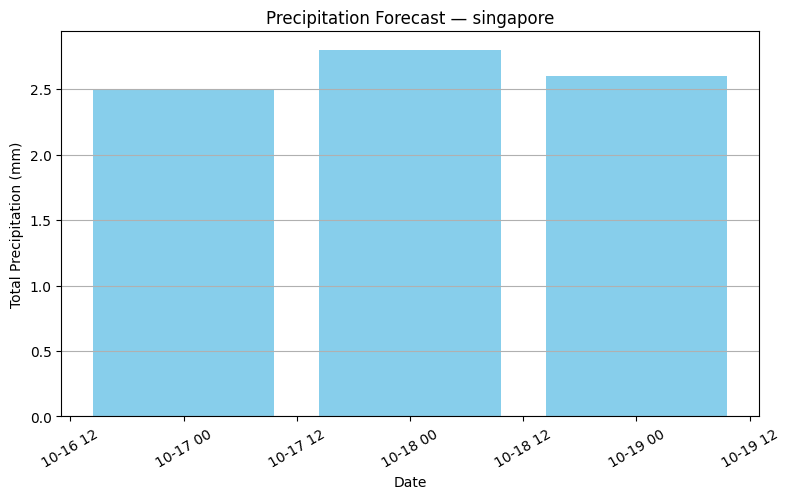

KeyboardInterrupt: Interrupted by user

In [33]:

from datetime import datetime
import matplotlib.pyplot as plt

def create_precipitation_visualisation(weather_data: dict, output_type: str = 'display'):
    """
    Create visualisation of precipitation data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    days = weather_data.get("forecast", [])
    if not days:
        raise ValueError("No forecast data to plot. Call get_weather_data(city, forecast_days>=1).")

    x_dates, y_precip = [], []
    for d in days:
        ds = d.get("date")
        if not ds:
            continue
        try:
            dt = datetime.strptime(ds, "%Y-%m-%d")
        except Exception:
            dt = datetime.fromisoformat(ds)
        x_dates.append(dt)
        y_precip.append(d.get("precip_mm"))

    if not x_dates:
        raise ValueError("No valid dates in forecast.")

    city = weather_data.get("current", {}).get("location", "Selected location")
    has_positive = any((p is not None) and (p > 0) for p in y_precip)

    fig = plt.figure(figsize=(9, 5))
    ax = plt.gca()

    if has_positive:
        ax.bar(x_dates, [p or 0 for p in y_precip], color='skyblue')
        ax.set_ylabel("Total Precipitation (mm)")
        ax.grid(True, axis='y')
    else:
        ax.set_axis_off()
        ax.text(
            0.5, 0.5, "No precipitation expected ☀️",
            ha="center", va="center", fontsize=13, transform=ax.transAxes
        )

    plt.title(f"Precipitation Forecast — {city}")
    plt.xlabel("Date")
    plt.xticks(rotation=30)

    if output_type == 'figure':
        return fig
    plt.show()


# --------------------- INTERACTIVE SECTION ---------------------

while True:
    city = input("\nEnter a city to view precipitation forecast (or type 'quit' to exit): ").strip()
    if city.lower() == "quit":
        print("👋 Exiting precipitation visualisation.")
        break

    try:
        data = get_weather_data(city, forecast_days=5)
        create_precipitation_visualisation(data)
    except Exception as e:
        print(f"⚠️ Could not fetch or display data for '{city}': {e}")



## 🤖 Natural Language Processing

In [ ]:
# Define parse_weather_question() and generate_weather_response() here
def parse_weather_question(question):
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """
    pass

## 🧭 User Interface

In [ ]:
# Define menu functions using pyinputplus or ipywidgets here

## 🧩 Main Application Logic

In [ ]:
# Tie everything together here
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    pass

## 🧪 Testing and Examples

In [ ]:
# Include sample input/output for each function

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.